# Import modules and Preporcessing

In [1]:
import pandas as pd
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Load images

In [2]:
dataset_root_folder = './flowers'

x_image = []
y_label = []

labels = os.listdir(dataset_root_folder)

for dirname in labels:
	filepath = os.path.join(dataset_root_folder, dirname)
	for file in os.listdir(filepath):
		filename = os.path.join(filepath, file)
		image = cv2.imread(filename)
		# image = cv2.resize(image, (300,300))
		x_image.append(image)
		y_label.append(dirname)

### Extract color histogram features

In [3]:
x_hist = []
color = ('b','g','r')

for img in x_image:
    ls = []
    for i,col in enumerate(color):
        hist = cv2.calcHist([img], [i], None, [256], [0, 256])
        ls.append(hist)
    x_hist.append(ls)

Visualize the color histogram of one of the image

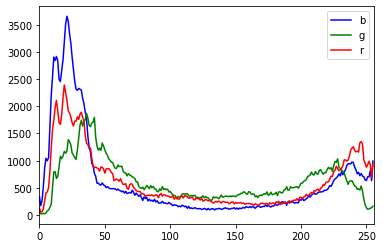

In [4]:
img_index = 15

plt.figure()
for i,col in enumerate(color):
    plt.plot(x_hist[img_index][i], color = col, label=color[i])
    plt.xlim([0,256])
    plt.legend()
plt.show()

### Split dataset into training, validation, and test

In [5]:
seed = 321

# To keep track of shuffled data and their indices to refer to the image
indexes_for_split = [x for x in range(len(x_hist))]
_, test_label_indexes, ___, ____ = train_test_split(indexes_for_split, y_label, test_size=0.2, random_state=seed, shuffle=True, stratify=y_label)

# Actual train test split of data
x_train_val, x_test, y_train_val, y_test = train_test_split(x_hist, y_label, test_size=0.2, random_state=seed, shuffle=True, stratify=y_label)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=seed, shuffle=True, stratify=y_train_val)

In [6]:
x_train = np.array(x_train, dtype=object)
x_val = np.array(x_val, dtype=object)
x_test = np.array(x_test, dtype=object)

In [7]:
nsamples, nx, ny, _ = x_train.shape
x_train_reshaped = x_train.reshape((nsamples, nx*ny))

nsamples, nx, ny, _ = x_val.shape
x_val_reshaped = x_val.reshape((nsamples, nx*ny))

nsamples, nx, ny, _ = x_test.shape
x_test_reshaped = x_test.reshape((nsamples, nx*ny))

# KNN

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sn
import time

Finding the right value of k

In [9]:
list_k = [x for x in range(1, 300)]
scores = []
for k in list_k:
    # print('k =', k)
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(x_train_reshaped, y_train)
    scores.append(neigh.score(x_val_reshaped, y_val))

Plot k and scores

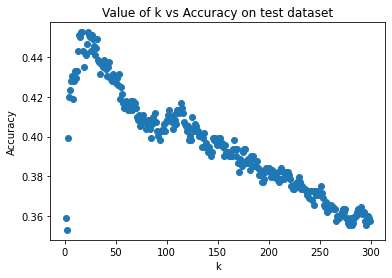

In [10]:
plt.scatter(list_k, scores)
plt.title("Value of k vs Accuracy on test dataset")
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()

Get the best value for k

In [11]:
index = scores.index(max(scores))
best_k = list_k[index]
print("Best k =", best_k, 'with an accuracy of', scores[index], 'on validation data')

Best k = 16 with an accuracy of 0.4525462962962963 on validation data


Build KNN with the best k value and use it on test dataset

In [12]:
neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(x_train_reshaped, y_train)
start_time = time.time()
score = neigh.score(x_test_reshaped, y_test)
duration = time.time() - start_time

print("accuracy on test dataset =", score)
print("time taken to execute =", duration, 'seconds')

accuracy on test dataset = 0.41087962962962965
time taken to execute = 0.15999913215637207 seconds


Evaluate accuracy

Text(33.0, 0.5, 'Truth')

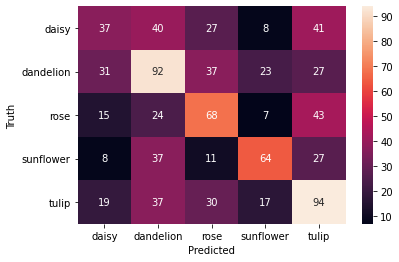

In [13]:
y_pred = neigh.predict(x_test_reshaped)
cm_labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred)

cm_array_df = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)

sn.heatmap(cm_array_df, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

Examples of correctly classified flowers

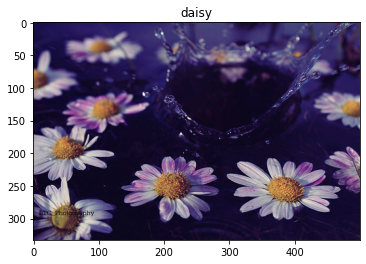

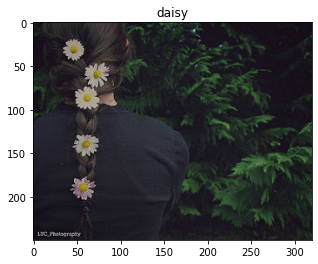

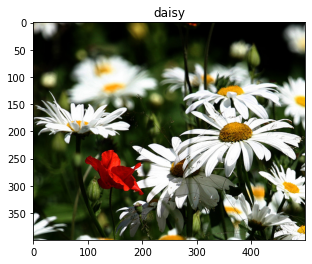

In [33]:
images_to_show = 3

# Find the indexes of the correctly classified flowers
indexes = []
for i, pred_flower in enumerate(y_pred):
        if pred_flower == y_test[i]:
            indexes.append(i)
            # Break out of loops if already found enough samples
            if len(indexes) >= images_to_show:
                break

for i in indexes:
    fig, ax1 = plt.subplots(1,1)
    ax1.set_title(y_test[i])
    ax1.imshow(cv2.cvtColor(x_image[test_label_indexes[i]], cv2.COLOR_BGR2RGB))
    plt.show()

Examples of wrongly classified flowers

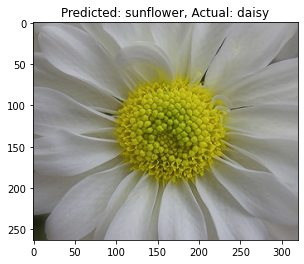

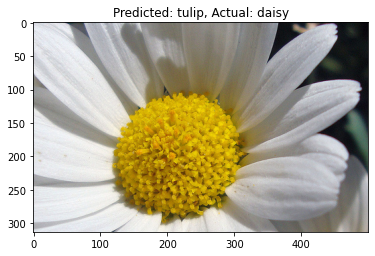

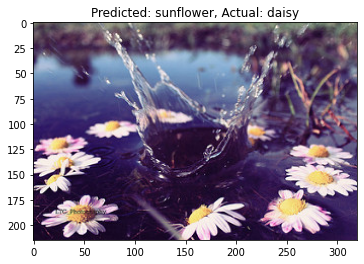

In [34]:
images_to_show = 3

# Find the indexes of the wrongly classified flowers
indexes = []
for i, pred_flower in enumerate(y_pred):
        if pred_flower != y_test[i]:
            indexes.append(i)
            # Break out of loops if already found enough samples
            if len(indexes) >= images_to_show:
                break

for i in indexes:
    fig, ax1 = plt.subplots(1,1)
    ax1.set_title(f'Predicted: {y_pred[i]}, Actual: {y_test[i]}')
    ax1.imshow(cv2.cvtColor(x_image[test_label_indexes[i]], cv2.COLOR_BGR2RGB))
    plt.show()